# HiPPO Matrices
---

## Load Packages

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from functools import partial
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from einops import rearrange, reduce, repeat

print(f"MPS enabled: {torch.backends.mps.is_available()}")

MPS enabled: False


In [3]:
## import packages
import math

import requests

from scipy import linalg as la
from scipy import signal
from scipy import special as ss

from src.data.process import moving_window, rolling_window

# import modules
from src.models.hippo.gu_transition import GuTransMatrix
from src.models.hippo.unroll import (
    basis,
    measure,
    variable_unroll_matrix,
    variable_unroll_matrix_sequential,
)

device = torch.device("cpu")
print(f"The Device: {device}")

The Device: cpu


In [4]:
torch.set_printoptions(linewidth=150)
np.set_printoptions(linewidth=150)

In [5]:
seed = 1701

## Instantiate The HiPPO Matrix

In [122]:
class HIPPO_LEGS(nn.Module):
    """Hippo class utilizing legs polynomial"""

    def __init__(self, N, gbt_alpha=0.5, maxlength=1024):
        super(HIPPO_LEGS, self).__init__()
        self.N = N
        self.gbt_alpha = gbt_alpha
        self.maxlength = maxlength

    def compute_A(self, n, k):
        """
        Computes the values for the HiPPO A matrix row by column
        using the piecewise equation on p. 31 eq. 29:
                (2n+1)^{1/2} (2k+ 1)^{1/2} if n > k
        A_{nk} = n+1                       if n = k,
                 0                         if n < k
        , where n represents the row and k the columns.

        Input:
            n (int):
                nth row of a square matrix of size N
            k (int):
                kth column of a square matrix of size N

        Returns:
            Values (float):
            Individual values for the elements in the A matrix.
        """
        if n > k:
            val = np.sqrt(2 * n + 1) * np.sqrt(2 * k + 1)
        if n == k:
            val = n + 1
        if n < k:
            val = 0
        return val

    def compute_B(self, n):
        """
        Computes the values for the HiPPO B matrix row by column
        using the piecewise equation on p. 31 eq. 29:
        B_{n} = (2n+1)^{1/2}

        Input:
            n (int):
                nth column of a square matrix of size N.

        Returns:
            Values (float):
            Individual values for the elements in the B matrix.
            The next hidden state (aka coefficients representing the function, f(t))
        """
        val = np.sqrt(2 * n + 1)
        return val

    def get_A_and_B(self, N):
        """
        Creates the HiPPO A and B matrix given the size N along a single axis of
        a square matrix.

        Input:
            N (int):
            Size N of a square matrix along a single axis.

        Returns:
            A (np.ndarray)
                shape: (N,N)
                the HiPPO A matrix.
            B (np.ndarray)
                shape: (N,):
                The HiPPO B matrix.
        """
        A = np.zeros((self.N, self.N))
        B = np.zeros((self.N, 1))

        for n in range(A.shape[0]):
            B[n][0] = self.compute_B(n)
            for k in range(A.shape[1]):
                A[n, k] = self.compute_A(n, k)

        return A * -1, B

    def generalized_bilinear_transform(self, A, B, t, gbt_alpha):
        """
        Performs the generalised bilinaer transform from p. 21 eq.13:
        c(t + ∆t) − ∆tαAc(t + ∆t) = (I + ∆t(1 − α)A)c(t) + ∆tBf(t)
        c(t + ∆t) = (I − ∆tαA)^{−1} (I + ∆t(1 − α)A)c(t) + ∆t(I − ∆tαA)^{−1}Bf(t).
        on the HiPPO matrix A and B, transforming them.
        Input:
            A (np.ndarray):
                shape: (N, N)
                the HiPPO A matrix
            B (np.ndarray):
                shape: (N,)
                the HiPPO B matrix
            Timestep t = 1/input length at t (int):

        Output:
            GBTA (np.array):
                shape: (N, N)
                Transformed HiPPO A matrix.

            GBTB (np.array):
                shape: (N,)
                Transformed HiPPO B matrix.
        """
        I = np.eye(A.shape[0])
        delta_t = 1 / t
        EQ13_p1 = I - (delta_t * gbt_alpha * A)
        EQ13_p2 = I + (delta_t * (1 - gbt_alpha) * A)

        EQA = np.linalg.lstsq(EQ13_p1, EQ13_p2, rcond=None)[0]
        EQB = np.linalg.lstsq(EQ13_p1, (delta_t * B), rcond=None)[0]
        return EQA, EQB

    def get_stacked_GBT(self):
        A, B = self.get_A_and_B(self.N)
        GBTA_stacked = np.empty((self.maxlength, self.N, self.N))
        GBTB_stacked = np.empty((self.maxlength, self.N, 1))

        for t in range(1, self.maxlength + 1):
            GBTA, GBTB = self.generalized_bilinear_transform(A, B, t, self.gbt_alpha)
            GBTA_stacked[t - 1] = GBTA
            GBTB_stacked[t - 1] = GBTB

        return GBTA_stacked, GBTB_stacked

    def discrete_hippo_operator(self, A, B, f, c_t=None):
        """
        Input:
            A (np.ndarray):
                shape: (N, N)
                the discretized A matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
            c_t (np.ndarray):
                shape: (batch size, input length, N)
                the initial hidden state
            f (np.ndarray):
                shape: (batch size, sequence length, 1)
                the input sequence
        Returns:
            The next hidden state (aka coefficients representing the function, f(t))
        """

        # f = torch.moveaxis(f, 0, 1)
        f = f.unsqueeze(-1)
        lst = []

        if c_t is None:
            c_t = np.zeros((f.shape[1], 1, self.N))

        for t, f_t in enumerate(f):

            part_1 = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float())
            part_2 = np.squeeze(B[t], -1) * f_t.numpy()

            c_t = part_1 + part_2
            lst.append(c_t)

        return c_t, np.stack(lst, axis=1)

    def reconstruct(self, c, B):
        vals = np.linspace(0.0, 1.0, self.maxlength)
        print(f"our vals shape:\n{vals.shape}")
        # np.expand_dims to unsqueeze last dim for mult: from np.arrange(N) shape [N,] to [N,1]
        print(f"Our Shape of B:\n{B.shape}")
        print(f"Our Shape of B:, None:\n{np.expand_dims(B,-1).shape}")
        eval_mat = (
            B * ss.eval_legendre(np.expand_dims(np.arange(self.N), -1), 2 * vals - 1)
        ).T
        print(f"Our eval mat shape:\n{eval_mat.shape}")
        a = eval_mat @ np.expand_dims(c, -1)
        print(f"Our s shape:\n{a.shape}")
        return a

    def forward():
        pass

In [7]:
class HiPPO_LSI(nn.Module):
    """Vanilla HiPPO-LegS model (scale invariant instead of time invariant)"""

    def __init__(
        self,
        N,
        method="legs",
        max_length=1024,
        discretization=0.5,
        lambda_n=1.0,
        alpha=0.0,
        beta=1.0,
    ):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        matrices = GuTransMatrix(
            N=N, measure=method, lambda_n=lambda_n, alpha=alpha, beta=beta
        )
        A = np.asarray(matrices.A, dtype=np.float32)
        B = np.asarray(matrices.B, dtype=np.float32)
        B = B.squeeze(-1)

        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)

        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            if discretization == 0.0:  # forward
                A_stacked[t - 1] = np.eye(N) + At
                B_stacked[t - 1] = Bt
            elif discretization == 1.0:  # backward
                A_stacked[t - 1] = la.solve_triangular(
                    np.eye(N) - At, np.eye(N), lower=True
                )
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
            elif discretization == 0.5:  # bilinear
                # A_stacked[t - 1] = la.solve_triangular(
                #     np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True
                # )
                # B_stacked[t - 1] = la.solve_triangular(
                #     np.eye(N) - At / 2, Bt, lower=True
                # )
                alpha = 0.5
                A_stacked[t - 1] = np.linalg.lstsq(
                    np.eye(N) - (At * alpha), np.eye(N) + (At * alpha), rcond=None
                )[
                    0
                ]  # TODO: Referencing this: https://stackoverflow.com/questions/64527098/numpy-linalg-linalgerror-singular-matrix-error-when-trying-to-solve
                B_stacked[t - 1] = np.linalg.lstsq(
                    np.eye(N) - (At * alpha), Bt, rcond=None
                )[0]

            else:  # ZOH
                A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
                # A_stacked[t - 1] = la.expm(At)
                B_stacked[t - 1] = la.solve_triangular(
                    A, A_stacked[t - 1] @ B - B, lower=True
                )

                # A_stacked[t - 1] = la.expm(At)
                # B_stacked[t - 1] = la.inv(A) @ (la.expm(At) - np.eye(A.shape[0])) @ B

        # self.register_buffer('A_stacked', torch.Tensor(A_stacked)) # (max_length, N, N)
        # self.register_buffer('B_stacked', torch.Tensor(B_stacked)) # (max_length, N)

        self.A_stacked = torch.Tensor(A_stacked.copy())  # (max_length, N, N)
        self.B_stacked = torch.Tensor(B_stacked.copy())  # (max_length, N)

        vals = np.linspace(0.0, 1.0, max_length)
        print(f"GU Shape of B:\n{B.shape}")
        print(f"GU Shape of B:, None:\n{B[:, None].shape}")
        # print(f"Shape of ss.val_legendre:\n{ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T}")
        self.eval_matrix = torch.from_numpy(
            np.asarray(
                ((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T)
            )
        )
        print(f"Eval matrix shape:\n{self.eval_matrix.shape}")

    def forward(self, inputs, fast=False):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """
        L = inputs.shape[0]
        inputs = inputs.unsqueeze(-1)
        u = torch.transpose(inputs, 0, -2)
        u = u * self.B_stacked[:L]
        u = torch.transpose(u, 0, -2)  # (length, ..., N)
        if fast:
            result = variable_unroll_matrix(self.A_stacked[:L], u)
            return result

        c = torch.zeros(u.shape[1:]).to(inputs)
        cs = []
        for t, f in enumerate(inputs):

            part1 = F.linear(c, self.A_stacked[t])
            part2 = self.B_stacked[t] * f
            c = part1 + part2
            cs.append(c)
        return torch.stack(cs, dim=0)

    def reconstruct(self, c):
        a = self.eval_matrix.to(c) @ c.unsqueeze(-1)
        print(f"GU a shape:\n{a.shape}")
        return a

In [8]:
# init HIPPO LEG S
def test_LegS(hippo, N):
    A, B = hippo.get_A_and_B(N=N)
    gu_legs_matrices = GuTransMatrix(N=N, measure="legs")
    gu_A, gu_B = gu_legs_matrices.A, gu_legs_matrices.B
    print(f"A:\n", A)
    print(f"A shape:\n", A.shape)
    print(f"Gu's A:\n", gu_A)
    print(f"Gu's A shape:\n", gu_A.shape)
    print(f"B:\n", B)
    print(f"B shape:\n", B.shape)
    print(f"Gu's B:\n", gu_B)
    print(f"Gu's B shape:\n", gu_B.shape)
    assert np.allclose(A, gu_A)
    assert np.allclose(B, gu_B)

In [9]:
test_LegS(hippo=HIPPO_LEGS(N=10), N=10)

A:
 [[ -1.          -0.          -0.          -0.          -0.          -0.          -0.          -0.          -0.          -0.        ]
 [ -1.73205081  -2.          -0.          -0.          -0.          -0.          -0.          -0.          -0.          -0.        ]
 [ -2.23606798  -3.87298335  -3.          -0.          -0.          -0.          -0.          -0.          -0.          -0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.          -0.          -0.          -0.          -0.          -0.          -0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.          -0.          -0.          -0.          -0.          -0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437  -6.          -0.          -0.          -0.          -0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383 -11.95826074  -7.          -0.          -0.          -0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.6189500

In [10]:
def gen_batch(batch_size=16, data_size=784, input_size=28):
    seed = 1701
    x = torch.randint(0, 255, (batch_size, data_size))
    x = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
    # Torch docs: torch.tensor.unfold(starting dim, window_size, step_size)
    x = x.unfold(1, input_size, 1)
    return x


batch_size = 2
data_size = 4
input_size = 1

N = 2
L = data_size

gen_data = gen_batch(batch_size=batch_size, data_size=data_size, input_size=input_size)

print(gen_data.shape)

torch.Size([2, 4, 1])


In [11]:
def test_GBT(the_measure="legs", lambda_n=1.0, gbt_alpha=0.5, discretization=0.5, N=50):
    batch_size = 16
    data_size = 256
    input_size = 1

    L = data_size

    x_np = gen_batch(batch_size=batch_size, data_size=data_size, input_size=input_size)
    print(x_np.shape)

    print(f"Creating Gu's HiPPO-{the_measure} LSI model with {gbt_alpha} transform")
    gu_hippo_lsi = HiPPO_LSI(
        N=N,
        method="legs",
        max_length=L,
        discretization=discretization,
        lambda_n=lambda_n,
        alpha=0.0,
        beta=1.0,
    )  # The Gu's

    print(f"Creating HiPPO-{the_measure} LTI model with {gbt_alpha} transform")
    hippo_lsi = HIPPO_LEGS(N=N, gbt_alpha=gbt_alpha)

    print(f"Testing for correct LTI GBT matrices for HiPPO-{the_measure}")
    test_LSI_GBT(hippo=hippo_lsi, gu_hippo=gu_hippo_lsi, alpha=gbt_alpha, N=N)

In [12]:
# our hippo, gu hippo, A, B matrix, random input, alpha
# def test_LSI_GBT(hippo, gu_hippo, A, B, random_input, alpha=0.5):
def test_LSI_GBT(hippo, gu_hippo, alpha=0.5, N=3):
    gen_data = gen_batch(
        batch_size=batch_size, data_size=data_size, input_size=input_size
    )

    GBT_A, GBT_B = hippo.get_stacked_GBT()

    L = gen_data.shape[1]
    for i in range(1, L + 1):

        gu_GBT_A, gu_GBT_B = (
            np.asarray(gu_hippo.A_stacked[i - 1], dtype=np.float32),
            np.expand_dims(
                np.asarray(gu_hippo.B_stacked[i - 1], dtype=np.float32), axis=1
            ),
        )
        print(f"GBT_A: {np.allclose(GBT_A[i-1], gu_GBT_A, rtol=1e-04, atol=1e-04)}")
        print(f"GBT_B: {np.allclose(GBT_B[i-1], gu_GBT_B, rtol=1e-04, atol=1e-04)}\n")

In [13]:
test_GBT(the_measure="legs", lambda_n=1.0, gbt_alpha=0.5, discretization=0.5, N=4)

torch.Size([16, 256, 1])
Creating Gu's HiPPO-legs LSI model with 0.5 transform
GU Shape of B:
(4,)
GU Shape of B:, None:
(4, 1)
Eval matrix shape:
torch.Size([256, 4])
Creating HiPPO-legs LTI model with 0.5 transform
Testing for correct LTI GBT matrices for HiPPO-legs
GBT_A: True
GBT_B: True

GBT_A: True
GBT_B: True

GBT_A: True
GBT_B: True

GBT_A: True
GBT_B: True



In [14]:
def test_hippo_operator(N=2, batch_size=2, data_size=4, input_size=1):
    gu_hippo = HiPPO_LSI(
        N=N,
        method="legs",
        max_length=1000,
        discretization=1.0,
        lambda_n=1.0,
        alpha=0.5,
        beta=1.0,
    )
    hippo = HIPPO_LEGS(N=N, gbt_alpha=1.0)
    inp = gen_batch(batch_size=batch_size, data_size=data_size, input_size=input_size)
    gu_inp = inp
    gu_inp = torch.moveaxis(inp, 0, 1)
    GBTA, GBTB = hippo.get_stacked_GBT()
    gu_c = gu_hippo(gu_inp, fast=False)
    _, our_c = hippo.discrete_hippo_operator(A=GBTA, B=GBTB, f=inp, c_t=None)
    our_c = np.moveaxis(our_c, 0, 1)

    assert (
        gu_c.shape == our_c.shape
    ), f"Shape mismatch between target {gu_c.shape} and computed coefficent matrix {our_c.shape}."
    print(
        f"Shape between target and computed coefficen matrix are equal:\n{gu_c.shape==our_c.shape}"
    )

    assert np.allclose(
        gu_c, np.float32(our_c), rtol=1e-04, atol=1e-04
    ), f"Mismatch between target and computed coefficent values"
    print(
        f"Coeffcient values between target and computed are equal:\n{np.allclose(gu_c, np.float32(our_c), rtol=1e-04, atol=1e-04)}"
    )

In [15]:
# Gu ck [length L, batch size, input size, size of N]
# our shoudl look like [batch_size, L , input size, size N]
test_hippo_operator(N=100, batch_size=1, data_size=512, input_size=1)

GU Shape of B:
(100,)
GU Shape of B:, None:
(100, 1)
Eval matrix shape:
torch.Size([1000, 100])
Shape between target and computed coefficen matrix are equal:
True
Coeffcient values between target and computed are equal:
True


/tmp/ipykernel_260/2559669833.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  part_1 = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float())


In [81]:
def test_hippo_reconstruct(
    N=2, batch_size=2, data_size=512, input_size=1, max_length=512
):
    gu_hippo = HiPPO_LSI(
        N=N,
        method="legs",
        max_length=max_length,
        discretization=0.5,
        lambda_n=1.0,
        alpha=0.5,
        beta=1.0,
    )
    hippo = HIPPO_LEGS(N=N, gbt_alpha=0.5, maxlength=max_length)
    inp = gen_batch(batch_size=batch_size, data_size=data_size, input_size=input_size)
    gu_inp = inp
    gu_inp = torch.moveaxis(inp, 0, 1)
    _, B = hippo.get_A_and_B(N=N)
    GBTA, GBTB = hippo.get_stacked_GBT()
    gu_c = gu_hippo(gu_inp, fast=False)
    _, our_c = hippo.discrete_hippo_operator(A=GBTA, B=GBTB, f=inp, c_t=None)
    our_c = np.moveaxis(our_c, 0, 1)
    gu_recon = gu_hippo.reconstruct(gu_c)
    our_recon = hippo.reconstruct(our_c, B)

    # assert np.allclose(gu_recon, np.float32(our_recon), rtol=1e-04, atol=1e-04), f"Mismatch between target and computed coefficent values"
    # print(f"Reconstructed values between target and computed are equal:\n{np.allclose(gu_recon, np.float32(our_recon), rtol=1e-04, atol=1e-04)}")

    return inp, gu_recon, our_recon

In [85]:
f, gu_recon, our_recon = test_hippo_reconstruct(
    N=512, batch_size=1, data_size=64, input_size=1, max_length=64
)

GU Shape of B:
(512,)
GU Shape of B:, None:
(512, 1)
Eval matrix shape:
torch.Size([64, 512])
GU a shape:
torch.Size([64, 1, 1, 64, 1])
our vals shape:
(64,)
Our Shape of B:
(512, 1)
Our Shape of B:, None:
(512, 1, 1)
Our eval mat shape:
(64, 512)
Our s shape:
(64, 1, 1, 64, 1)


/tmp/ipykernel_260/2559669833.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  part_1 = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float())


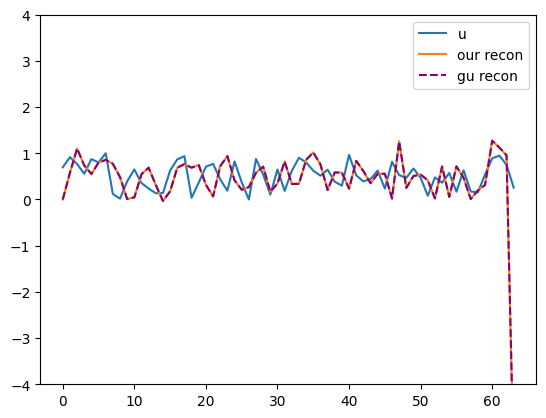

In [104]:
from IPython.display import clear_output

for i in range(f[0].shape[0]):
    clear_output(wait=True)
    ax = plt.gca()
    ax.set_ylim([-4, 4])
    plt.plot(f[0], label="u")
    plt.plot(np.squeeze(np.moveaxis(our_recon, 0, 1), -1)[0][i].T, label="our recon")
    plt.plot(
        torch.squeeze(torch.moveaxis(gu_recon, 0, 1), -1)[0][i].T,
        linestyle="--",
        color="purple",
        label="gu recon",
    )
    plt.legend()
    plt.show()

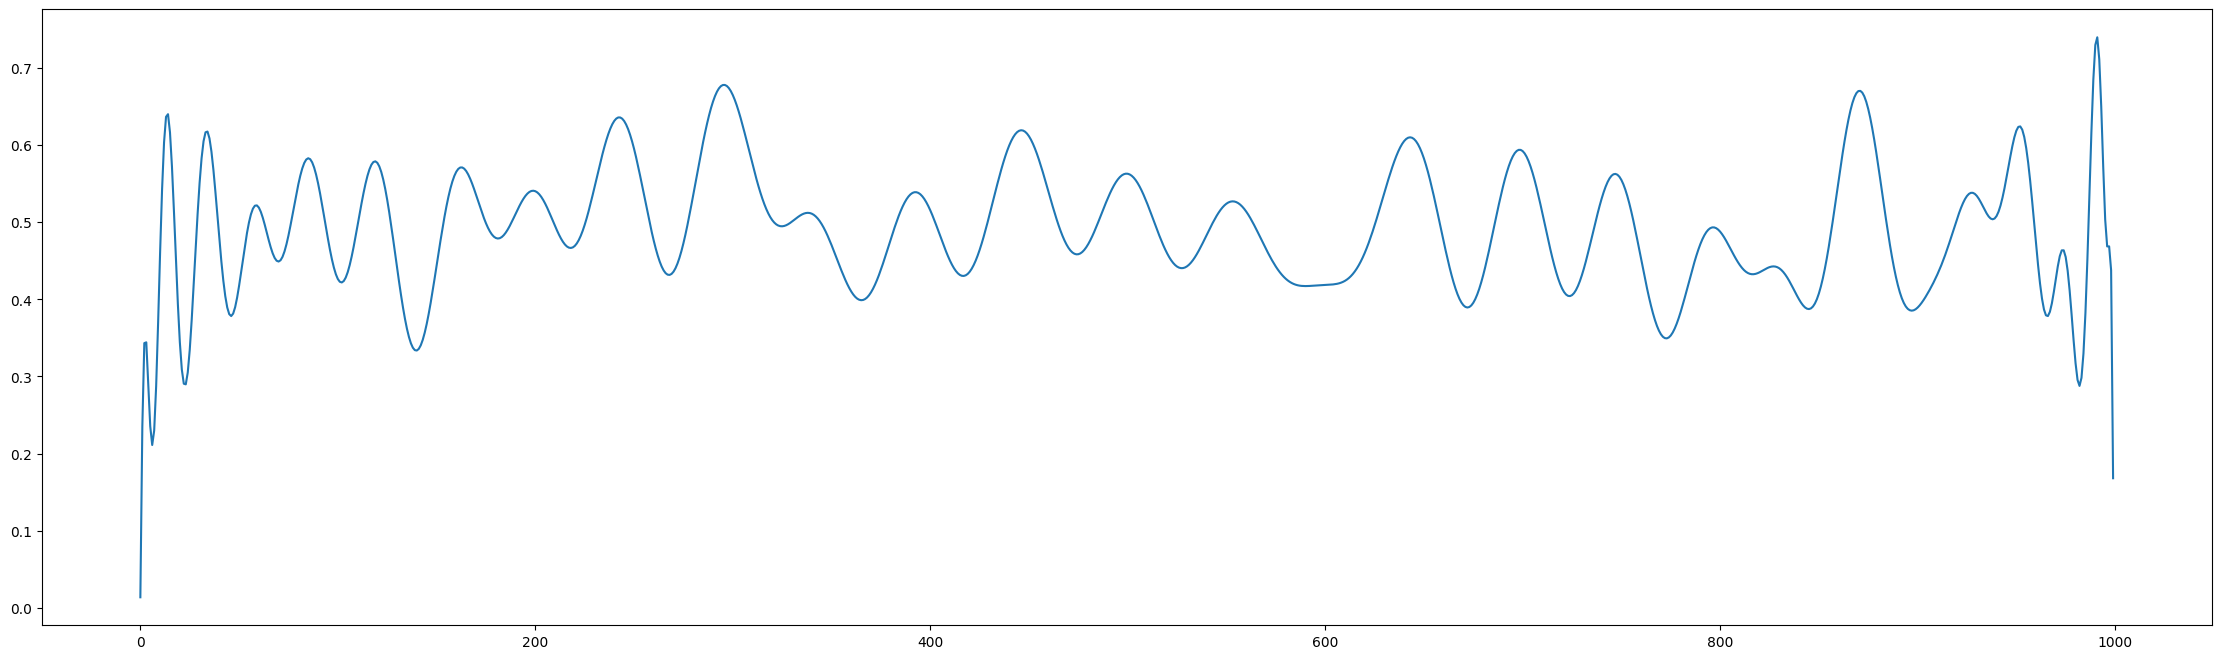

In [22]:
plt.figure(figsize=(28, 8))
plt.plot()

In [21]:
# data size, batch size, input size, max length timestep, empty singleton dim
print(our_recon.shape)
# batch size, data size, input size, max length timestep, empty singleton dim
print(np.moveaxis(our_recon, 0, 1).shape)
# batch size, data size, input size, max length timestep
print(np.squeeze(np.moveaxis(our_recon, 0, 1), -1).shape)
# data size, input size, max length timestep
print(np.squeeze(np.moveaxis(our_recon, 0, 1), -1)[0].shape)
# data size, input size, max length timestep
print(np.squeeze(np.moveaxis(our_recon, 0, 1), -1)[0][-1].T.shape)


# data size, batch size, input size, max length timestep, empty singleton dim
print(gu_recon.shape)
# batch size, data size, input size, max length timestep, empty singleton dim
print(torch.moveaxis(gu_recon, 0, 1).shape)
# batch size, data size, input size, max length timestep
print(torch.squeeze(torch.moveaxis(gu_recon, 0, 1), -1).shape)
# data size, input size, max length timestep
print(torch.squeeze(torch.moveaxis(gu_recon, 0, 1), -1)[0].shape)
# data size, input size, max length timestep
print(torch.squeeze(torch.moveaxis(gu_recon, 0, 1), -1)[0][-1].T.shape)

(1000, 1, 1, 1000, 1)
(1, 1000, 1, 1000, 1)
(1, 1000, 1, 1000)
(1000, 1, 1000)
(1000, 1)
torch.Size([1000, 1, 1, 1000, 1])
torch.Size([1, 1000, 1, 1000, 1])
torch.Size([1, 1000, 1, 1000])
torch.Size([1000, 1, 1000])
torch.Size([1000, 1])


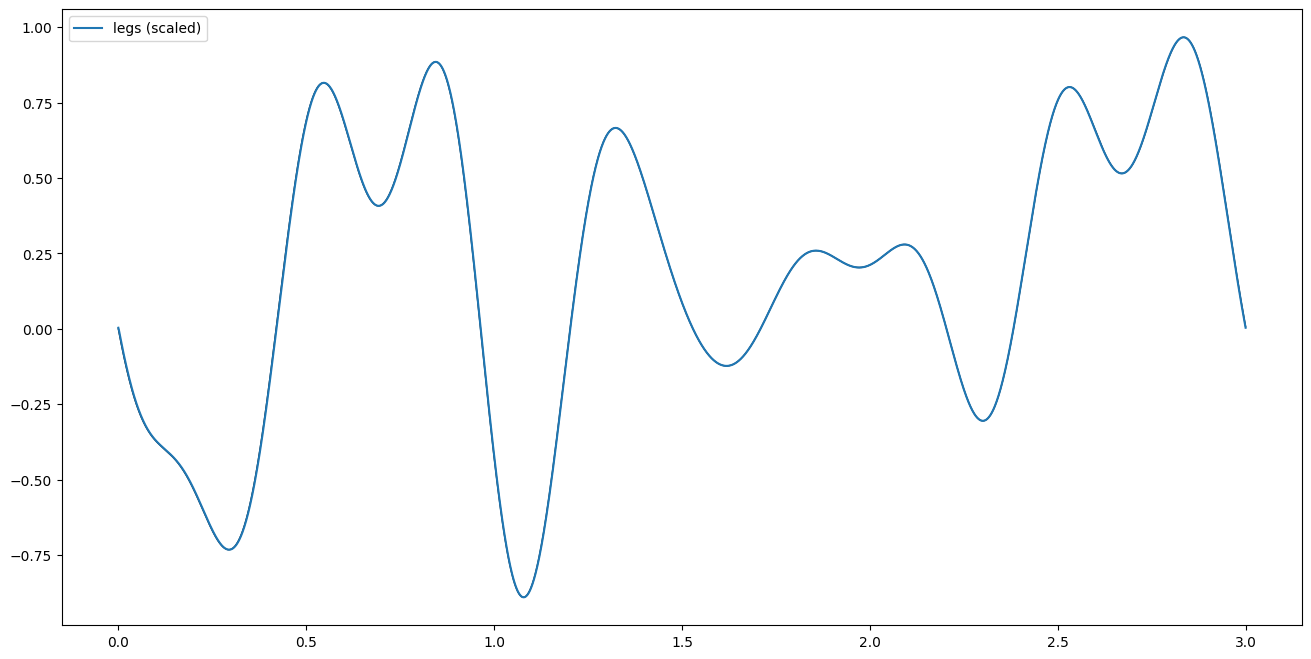

In [112]:
def transition(measure, N, **measure_args):
    # Laguerre (translated)
    if measure == "lagt":
        b = measure_args.get("beta", 1.0)
        A = np.eye(N) / 2 - np.tril(np.ones((N, N)))
        B = b * np.ones((N, 1))
    # Legendre (translated)
    elif measure == "legt":
        Q = np.arange(N, dtype=np.float64)
        R = (2 * Q + 1) ** 0.5
        j, i = np.meshgrid(Q, Q)
        A = R[:, None] * np.where(i < j, (-1.0) ** (i - j), 1) * R[None, :]
        B = R[:, None]
        A = -A
    # Legendre (scaled)
    elif measure == "legs":
        q = np.arange(N, dtype=np.float64)
        col, row = np.meshgrid(q, q)
        r = 2 * q + 1
        M = -(np.where(row >= col, r, 0) - np.diag(q))
        T = np.sqrt(np.diag(2 * q + 1))
        A = T @ M @ np.linalg.inv(T)
        B = np.diag(T)[:, None]
        B = (
            B.copy()
        )  # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
    elif measure == "fourier":
        freqs = np.arange(N // 2)
        d = np.stack([np.zeros(N // 2), freqs], axis=-1).reshape(-1)[1:]
        A = 2 * np.pi * (-np.diag(d, 1) + np.diag(d, -1))
        B = np.zeros(N)
        B[0::2] = 2
        B[0] = 2**0.5
        A = A - B[:, None] * B[None, :]
        # A = A - np.eye(N)
        B *= 2**0.5
        B = B[:, None]

    return A, B


class HiPPOScale(nn.Module):
    """Vanilla HiPPO-LegS model (scale invariant instead of time invariant)"""

    def __init__(self, N, method="legs", max_length=1024, discretization="bilinear"):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        A, B = transition(method, N)
        B = B.squeeze(-1)
        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)
        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            if discretization == "forward":
                A_stacked[t - 1] = np.eye(N) + At
                B_stacked[t - 1] = Bt
            elif discretization == "backward":
                A_stacked[t - 1] = la.solve_triangular(
                    np.eye(N) - At, np.eye(N), lower=True
                )
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
            elif discretization == "bilinear":
                A_stacked[t - 1] = la.solve_triangular(
                    np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True
                )
                B_stacked[t - 1] = la.solve_triangular(
                    np.eye(N) - At / 2, Bt, lower=True
                )
            else:  # ZOH
                A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
                B_stacked[t - 1] = la.solve_triangular(
                    A, A_stacked[t - 1] @ B - B, lower=True
                )
        self.register_buffer("A_stacked", torch.Tensor(A_stacked))  # (max_length, N, N)
        self.register_buffer("B_stacked", torch.Tensor(B_stacked))  # (max_length, N)

        vals = np.linspace(0.0, 1.0, max_length)
        self.eval_matrix = torch.Tensor(
            (B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T
        )

    def forward(self, inputs, fast=False):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """

        L = inputs.shape[0]

        inputs = inputs.unsqueeze(-1)
        u = torch.transpose(inputs, 0, -2)
        u = u * self.B_stacked[:L]
        u = torch.transpose(u, 0, -2)  # (length, ..., N)

        if fast:
            result = unroll.variable_unroll_matrix(self.A_stacked[:L], u)
            return result

        c = torch.zeros(u.shape[1:]).to(inputs)
        cs = []
        for t, f in enumerate(inputs):
            c = F.linear(c, self.A_stacked[t]) + self.B_stacked[t] * f
            cs.append(c)
        return torch.stack(cs, dim=0)

    def reconstruct(self, c):
        a = self.eval_matrix.to(c) @ c.unsqueeze(-1)
        return a


def whitesignal(period, dt, freq, rms=0.5, batch_shape=()):
    """
    Produces output signal of length period / dt, band-limited to frequency freq
    Output shape (*batch_shape, period/dt)
    Adapted from the nengo library
    """

    if freq is not None and freq < 1.0 / period:
        raise ValueError(
            f"Make ``{freq=} >= 1. / {period=}`` to produce a non-zero signal",
        )

    nyquist_cutoff = 0.5 / dt
    if freq > nyquist_cutoff:
        raise ValueError(
            f"{freq} must not exceed the Nyquist frequency for the given dt ({nyquist_cutoff:0.3f})"
        )

    n_coefficients = int(np.ceil(period / dt / 2.0))
    shape = batch_shape + (n_coefficients + 1,)
    sigma = rms * np.sqrt(0.5)
    coefficients = 1j * np.random.normal(0.0, sigma, size=shape)
    coefficients[..., -1] = 0.0
    coefficients += np.random.normal(0.0, sigma, size=shape)
    coefficients[..., 0] = 0.0

    set_to_zero = np.fft.rfftfreq(2 * n_coefficients, d=dt) > freq
    coefficients *= 1 - set_to_zero
    power_correction = np.sqrt(1.0 - np.sum(set_to_zero, dtype=float) / n_coefficients)
    if power_correction > 0.0:
        coefficients /= power_correction
    coefficients *= np.sqrt(2 * n_coefficients)
    signal = np.fft.irfft(coefficients, axis=-1)
    signal = signal - signal[..., :1]  # Start from 0
    return signal


def plot(T, dt, N, freq):
    np.random.seed(0)
    vals = np.arange(0.0, T, dt)

    u = whitesignal(T, dt, freq=freq)
    u = torch.tensor(u, dtype=torch.float)
    u = u.to(device)

    plt.figure(figsize=(16, 8))
    offset = 0.0
    plt.plot(vals, u.cpu() + offset, "k", linewidth=1.0)

    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        "legs",
        "legt",
        "fourier",
    ]

    for method in lti_methods:
        hippo = HiPPO(method=method, N=N, dt=dt, T=T).to(device)
        u_hippo = hippo.reconstruct(hippo(u))[-1].cpu()
        plt.plot(vals[-len(u_hippo) :], u_hippo, label=method)

    # Original HiPPO-LegS, which uses time-varying SSM x' = 1/t [ Ax + Bu]
    # we call this "linear scale invariant"
    lsi_methods = ["legs"]
    for method in lsi_methods:
        hippo = HiPPOScale(N=N, method=method, max_length=int(T / dt)).to(device)
        u_hippo = hippo.reconstruct(hippo(u))[-1].cpu()
        plt.plot(vals[-len(u_hippo) :], u_hippo, label=method + " (scaled)")

    # plt.xlabel('Time (normalized)', labelpad=-10)
    plt.legend()
    plt.savefig(f"function_approximation.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

    return u, u_hippo


sig, sigrecom = plot(T=3, dt=1e-3, N=64, freq=3.0)

In [123]:
hippoour = HIPPO_LEGS(N=64, gbt_alpha=0.5, maxlength=3000)
inp = sig
_, B = hippoour.get_A_and_B(N=N)
GBTA, GBTB = hippoour.get_stacked_GBT()
_, our_c = hippoour.discrete_hippo_operator(A=GBTA, B=GBTB, f=inp, c_t=None)
our_c = np.moveaxis(our_c, 0, 1)
our_recon = hippoour.reconstruct(our_c, B)

/tmp/ipykernel_260/641251527.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  part_1 = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float())


our vals shape:
(3000,)
Our Shape of B:
(64, 1)
Our Shape of B:, None:
(64, 1, 1)
Our eval mat shape:
(3000, 64)
Our s shape:
(3000, 1, 1, 3000, 1)


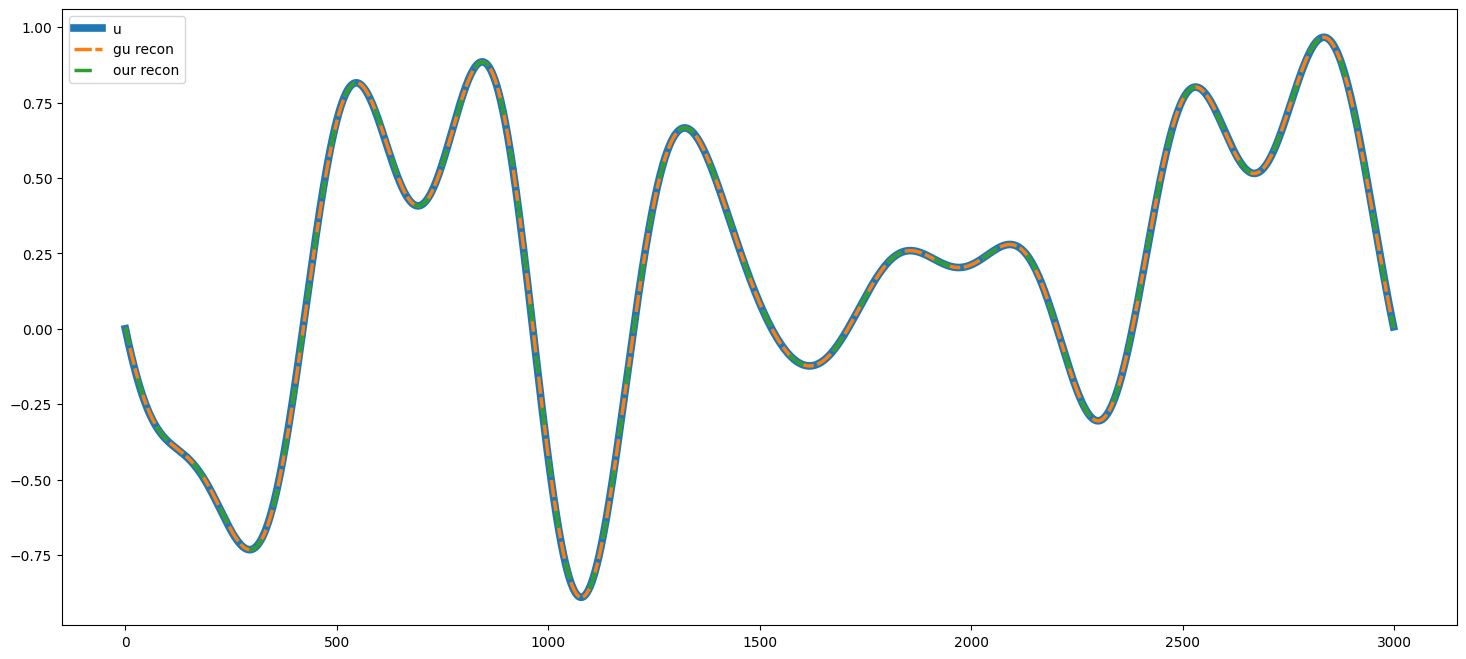

In [145]:
plt.figure(figsize=(18, 8))
plt.plot(sig, label="u", linewidth=5.5)
plt.plot(sigrecom, linestyle="--", label="gu recon", dashes=(5, 1), linewidth=2.5)
plt.plot(
    np.squeeze(np.moveaxis(our_recon, 0, 1), -1)[0][-1].T,
    linestyle=":",
    label="our recon",
    dashes=(5, 10),
    linewidth=2.5,
)
plt.legend()

In [125]:
our_recon.shape

(3000, 1, 1, 3000, 1)